# Detecting patterns of speciation in the fos- sil record

In this assignment, we use data from the NOW (New and Old Worlds) database of fossil mammals to study patterns of speciation over time and space. In particular, we are interested to know when and where speciation rates have been significantly high. The task is to find which time periods and which places over the history of mammals have given rise to exceptionally high numbers of new species. The phenomenon is known in the evolutionary literature as the “species factory”. Palaeontologists are interested why and in which ways those times and places are special. The role of computational science is to identify and characterize such times and places.
We practice using pandas DataFrames, performing logistic regression and making statistical significance tests in data analysis.

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import random
import statsmodels.api as sm
import scipy

random.seed(31)

# Exercise 1, 2 and 3a
def data():
    # Reads the data from txt file and saves it to csv from.
    df = pd.read_csv('fossil_data.txt')
    df.to_csv('fossil_data.csv')
    df = pd.read_csv('fossil_data.csv', sep=',') #76627 rows x 103 columns

    # Cleans the data; LAT = LONG = 0, and SPECIES = 'sp.' or 'indet.'
    clean_latlong = df[ (df['LAT'] == 0) | (df['LONG'] == 0) ].index
    df.drop(clean_latlong, inplace=True) # 76623 rows x 103 columns
    clean_species = df[ (df['SPECIES'] == 'sp.') | (df['SPECIES'] == 'indet.') ].index
    df.drop(clean_species, inplace=True) # 56177 rows x 103 columns

    #Returns the cleaned dataframe
    return df


In [89]:
# Excercise 3b and 3c
def mammal_neogene(data):
    df = pd.DataFrame(data)
    # Setup column for MAMMAL NEOGENE and assig nan values to it
    df['MAMMAL_NEOGENE'] = np.nan

    # Dict with the appropriate MN(MAMMAL_NEOGENE) zone and max-, min-age in millions of years
    mn_dict = {'MN1':[23, 21.7], 'MN2': [21.7, 19.5], 'MN3': [19.5, 17.2], 'MN4': [17.2, 16.4], 'MN5': [16.4, 14.2],
          'MN6': [14.2, 12.85], 'MN7-8': [12.85, 11.2], 'MN9': [11.2, 9.9], 'MN10': [9.9, 8.9],
          'MN11': [8.9, 7.6], 'MN12': [7.6, 7.1], 'MN13': [7.1, 5.3], 'MN14': [5.3, 5.0], 'MN15': [5.0, 3.55],
          'MN16': [3.55, 2.5], 'MN17': [2.5, 1.9],  'MQ18': [1.9, 0.85], 'MQ19': [0.85, 0.01]}  #Could dataframe work better?
    
    
    
    # Loop through the data rows
    for i in df.index:
        # Calculate the mean age of an fossil occurance
        mean_age = (df.loc[i, 'MIN_AGE'] + df.loc[i, 'MAX_AGE']) / 2

        # Assignin pre- and post-MN values for occurances outside of the MN intervals
        if mean_age > mn_dict['MN1'][0]: df.loc[i, 'MAMMAL_NEOGENE'] = 'pre-MN'
        elif mean_age < mn_dict['MQ19'][1]: df.loc[i, 'MAMMAL_NEOGENE'] = 'post-MN'

        # Assigning the correct MN for every occurance based on the mean_age
        # If the mean age of an occurrence is precisely on the boundary between two time units, assign the occurrence to the older time unit
        else:
            for mn, age, in mn_dict.items():
                max, min = age
                if mean_age <= max and mean_age >= min: 
                    df.loc[i, 'MAMMAL_NEOGENE'] = mn
                    break

    # Assignin konwn MN-values for specific locations
    df.loc[df['NAME'] == 'Samos Main Bone Beds', 'MAMMAL_NEOGENE'] = 'MN12'
    df.loc[df['NAME'] == 'Can Llobateres I', 'MAMMAL_NEOGENE'] = 'MN9'

    # Return the updated dataframe               
    return df

In [90]:
# Excercise 3d, 3e and 3f
def species_id(data):
    # Assigns unique id number for every unique combination of GENUS ans SPECIES
    df = pd.DataFrame(data)

    # Creates new column SPECIES_ID and assigns GENUS + SPECIES combination to it
    df['SPECIES_ID'] = df['GENUS'] + ' ' + df['SPECIES']

    # From the GENUS + SPECIES combination pd.factorize creates unigue id numbers
    species_ids, species_name = pd.factorize(df['SPECIES_ID'])
    
    # Assign unique id numbers to fossil occurances
    df['SPECIES_ID'] = species_ids + 1

    # Deleting duplicate species_ids from same locality
    # Every locality should only contain one of every species
    df = df[df.groupby(['NAME', 'SPECIES_ID']).cumcount() == 0] # 56143 rows x 105 columns

    # Return updated dataframe
    return df


In [91]:
# excercise 4
def find_first_occurrence(row):
    # Helper function to iterate over columns to find the column which is first one with a greater value than 0, thus get the oldest MN value
    for col in row.index:
        if col != 'SPECIES_ID' and row[col] > 0:
            return col
    return None

# excercise 4
def fossil_occurrences(data, id='SPECIES_ID'):
    df_data = pd.DataFrame(data)
    # Dataframe for the fossil occurances in different mammal negene 
    df_occurrences = pd.DataFrame(columns=['SPECIES_ID', 'pre-MN', 'MN1', 'MN2', 'MN3', 'MN4', 'MN5', 'MN6', 'MN7-8', 'MN9', 'MN10',
                                        'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN16', 'MN17', 'MQ18', 'MQ19', 'post-MN'])
    
    # Group by species_id and mammal neogene and calculate the occurrences of those
    species_occurrences = df_data.groupby([id, 'MAMMAL_NEOGENE']).size().reset_index(name='OCCURRENCES')
    species_occurrences_pivot = species_occurrences.pivot_table(index=id, columns='MAMMAL_NEOGENE', values='OCCURRENCES', fill_value=0)

    # Update the values to the df_occurances dataframe
    df_occurrences['SPECIES_ID'] = species_occurrences_pivot.index
    df_occurrences.set_index('SPECIES_ID', inplace=True)
    df_occurrences.update(species_occurrences_pivot)

    # Creates new dataframe with species id and when it was first time observed
    df_first_occurrences = df_occurrences.apply(find_first_occurrence, axis=1).reset_index(name='FIRST_OCCURRENCE')

    
    return(df_occurrences, df_first_occurrences)


In [92]:
# Excercise 4 plotting
def plot_occurrences(total_occurrences, total_first_occurrences, proportion_first_occurrences):
    # Plot occurances to a horizontal table
    plt.figure(figsize=(8, 6))
    plt.barh(proportion_first_occurrences.index[::-1], proportion_first_occurrences[::-1])
    plt.xlabel('Precentage of First Occurrences')
    plt.ylabel('Mammal Neogene')
    plt.title('Proportion of First Occurrences Over Time in each MN')
    for i, v in enumerate(proportion_first_occurrences[::-1]):
        plt.text(v, i, f'{v:.2f}%', ha='left', va='center', fontsize=8)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.barh(total_occurrences.index[::-1], total_occurrences[::-1])
    plt.xlabel('Total Occurrences')
    plt.ylabel('Mamma Neogene')
    plt.title('Total Number of Occurrences Over Time')
    for i, v in enumerate(total_occurrences[::-1]):
        plt.text(v, i, str(v), ha='left', va='center', fontsize=8)
    plt.tight_layout()
    plt.show()

In [93]:
def calculate_occurrences(occurrences, first_occurrences):
    # Calculates the total occurances, total first occurances and proportion of first occurances
    total_occurrences = occurrences.sum()
    total_first_occurrences = first_occurrences['FIRST_OCCURRENCE'].value_counts().reindex(total_occurrences.index, fill_value=0)
    proportion_first_occurrences = total_first_occurrences / total_occurrences

    return total_occurrences, total_first_occurrences, proportion_first_occurrences

In [94]:
# Excercise 5a
def locality(data):
    df_data = pd.DataFrame(data)

    # For every locality id (LIDNUM) get MN occurrences, using lidnum and not name because same area (name) can have multiple localities(lidnum)
    # lidnum is specific are id and number id is faster and easier to process
    df_occurrences, df_first_occurrences = fossil_occurrences(df_data)

    # Create a DataFrame to hold unique locality information
    df_locality = pd.DataFrame({'LOCALITY_ID': df_data['LIDNUM'].unique()})
    df_locality = pd.merge(df_locality, df_data[['LIDNUM', 'LONG', 'LAT', 'MAMMAL_NEOGENE']], left_on='LOCALITY_ID', right_on='LIDNUM', how='left')

    df_locality.drop(columns='LIDNUM', inplace=True)
    df_locality.drop_duplicates(inplace=True)
    df_locality.reset_index(drop=True, inplace=True)

    # Calculate total occurrences for each unique locality
    total_occurances = df_data.groupby('LIDNUM')['SPECIES_ID'].count()
    df_locality = pd.merge(df_locality, total_occurances, left_on='LOCALITY_ID', right_on='LIDNUM', how='left')
    df_locality.rename(columns={'SPECIES_ID': 'ALL_OCCURRENCES'}, inplace=True)

    # Merge data to find first occurrences in each locality
    merged_data = pd.merge(df_data, df_first_occurrences, on='SPECIES_ID', how='left')
    merged_locality = pd.merge(df_locality, merged_data, left_on='LOCALITY_ID', right_on='LIDNUM', how='left')
    filtered_locality = merged_locality[merged_locality['MAMMAL_NEOGENE_x'] == merged_locality['FIRST_OCCURRENCE']]

    # Calculate number of first occurrences for each locality
    locality_first_occurrences = filtered_locality.groupby('LOCALITY_ID').size().reset_index(name='NUMBER_OF_FIRST_OCCURRENCES')
    df_locality = pd.merge(df_locality, locality_first_occurrences, on='LOCALITY_ID', how='left')
    df_locality['NUMBER_OF_FIRST_OCCURRENCES'] = df_locality['NUMBER_OF_FIRST_OCCURRENCES'].fillna(0).astype('int')

    # Calculate proportion of first occurrences for each locality
    df_locality['PROPORTION_OF_FIRST_OCCURRENCES'] = df_locality['NUMBER_OF_FIRST_OCCURRENCES'] / df_locality['ALL_OCCURRENCES']
     
    return df_locality


In [95]:
# Excercise 5b, helper function
def world_plot():
    # Plots the world map
    world = (gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')))
    fig, ax = plt.subplots(figsize=(20, 10))
    world.plot(ax=ax, color='wheat', edgecolor='black')
    ax.set_facecolor('azure')
    
    # Returns the ready to use world map plot
    return plt


In [96]:
# Excercise 5b
def plot_localities_on_world_map(data):
    # Visualize the distribution of localities in space and time.
    world = world_plot()
    time_units = sorted(data['MAMMAL_NEOGENE'].unique())
    time_unit_colors = {time_unit: "#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for time_unit in time_units}
    
    # Plot localities for each time unit
    for time_unit in time_units:
        df_time_unit = data[data['MAMMAL_NEOGENE'] == time_unit]
        marker_size = df_time_unit['ALL_OCCURRENCES'] * 1.3
        world.scatter(df_time_unit['LONG'], df_time_unit['LAT'], s=marker_size, label=time_unit, color=time_unit_colors[time_unit], alpha=0.7)

    # Add labels and title
    plt.xlabel('LONGITUDE')
    plt.ylabel('LATITUDE')
    plt.title('Distribution of Localities in Space and Time')
    plt.legend()
    
    # Display the plot
    plt.show()
    

    ### Excercise 5c ###

# Based on exercises 4 and 5, what kind of observations about sampling can you make? 

# Most of occurrences are done in pre-MN or MQ18 time-period and most findings are done in middle of Europe, North-america and East of Asia. 
# Proprotion of first occurrences are higest in pre-MN and MN1. Lowest proportion of first occurrences are in MQ19 time-unit.

# Are there differences in sampling density over space and time? 

# Yes, there can clearly see difference in where the most findings are done and the time period.
# Most of findings are in Central-Europe and North-America and both has the pre-MN time unit. 
# Third most findings are in east of Asia and those findings are mostly in the MQ19 time-unit

# Compare some basic sampling properties between Africa, Asia and Europe, e.g. spatial coverage and average number of occurrences per locality.

# Again most of data is gathered from North-America, Central-Europe, East of Asia and South/East of Africa.
# Africa and Asia is mostly MQ19/MQ18 period and America is pre-MN.
# Europe is a bit of mix of both, West of Europe is more pre-MN, 
# East of Europe is MQ19, South of Europe is a mix on multiple times and "North" (around baltic, Eastonia, Latvia, Lithuenia) Europe is MN5.
# So there can bee seen strong difference in areas where fossils are found.
    

In [97]:
# Excercise 6
def get_preceding_time_unit(time_unit):
    # Get the preceding time unit for a given time unit.
    time_units_order = ['pre-MN', 'MN1', 'MN2', 'MN3', 'MN4', 'MN5', 'MN6', 'MN7-8', 'MN9', 'MN10', 'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN16', 'MN17', 'MQ18', 'MQ19' ,'post-MN']
    if time_unit in time_units_order:
        idx = time_units_order.index(time_unit)
        if idx == 0:
            return None  # No preceding time unit for the first time unit
        else:
            return time_units_order[idx - 1]
    else:
        return None


# Excercise 6
def locality_10_x_10(data):
    # Calculate locality-specific statistics within a 10x10 degree area around each locality.
    df = pd.DataFrame(data)
    for i, row in df.iterrows():
        long_min = row['LONG'] - 5.0
        long_max = row['LONG'] + 5.0
        lat_min = row['LAT'] - 5.0
        lat_max = row['LAT'] + 5.0

        # Filter data
        occurrences_10x10 = (df['LONG'].between(long_min, long_max)) & (df['LAT'].between(lat_min, lat_max))
        df.at[i, 'TOTAL_OCCURRENCES_10X10'] = df.loc[occurrences_10x10, 'ALL_OCCURRENCES'].sum()
        df.at[i, 'FIRST_OCCURRENCES_10X10'] = df.loc[occurrences_10x10, 'NUMBER_OF_FIRST_OCCURRENCES'].sum()

        # Get preceding time unit
        preceding_time_unit = get_preceding_time_unit(row['MAMMAL_NEOGENE'])

        # Calculate preceding occurrences
        if preceding_time_unit is not None:
            df.at[i, 'PRECEDING_OCCURRENCES_10X10'] = df.loc[(df['MAMMAL_NEOGENE'] == preceding_time_unit) & occurrences_10x10,'ALL_OCCURRENCES'].sum()
        else:
            df.at[i, 'PRECEDING_OCCURRENCES_10X10'] = None

    return df

In [98]:
# Excercise 7abc
def regres(data):
    # Perform logistic regression analysis on fossil occurrence data in localities within
    # the co-ordinates -25<LONG<40 and LAT>35 and time unit within MN2-MQ19.

    # Filter data 
    filtered_data = data[(data['LONG'] > -25) & (data['LONG'] < 40) & 
                                (data['LAT'] > 35) & (data['MAMMAL_NEOGENE'].between('MN2', 'MQ19'))]
    
    # Generate locality-related data and occurrence statisticsc
    locality_data = locality(filtered_data)
    locality_data = locality_10_x_10(locality_data)
    occurrences, first_occurrences = fossil_occurrences(filtered_data)

    # Merge relevant data for analysis
    merged_data = pd.merge(filtered_data, locality_data, left_on='LIDNUM', right_on='LOCALITY_ID', how='left')
    merged_data = pd.merge(merged_data, first_occurrences, on='SPECIES_ID', how='left')

    # Prepare dataset for logistic regression
    df_dataset = pd.DataFrame()
    df_dataset['PRECEDING_OCCURRENCES_10X10'] = merged_data['PRECEDING_OCCURRENCES_10X10']
    df_dataset['FIRST_OCCURRENCE'] = (merged_data['MAMMAL_NEOGENE_x'] == merged_data['FIRST_OCCURRENCE']).astype(int)
    

    X = df_dataset['PRECEDING_OCCURRENCES_10X10']
    X = sm.add_constant(X)
    y = df_dataset['FIRST_OCCURRENCE']
    
    # Perform logistic regression
    model = sm.Logit(y, X)
    result = model.fit()

    # Print regression summary
    print(result.summary())

    # Calculate expected first occurrences
    x_values = np.linspace(X['PRECEDING_OCCURRENCES_10X10'].min(), X['PRECEDING_OCCURRENCES_10X10'].max(), 100)
    x_values_with_const = sm.add_constant(x_values)

    # Calculate the predicted probabilities using the logistic regression coefficients
    predicted_probs = result.predict(x_values_with_const)
    ci = result.get_prediction(x_values_with_const).conf_int()


    # Plot the expected counts and confidence intervals
    plt.figure(figsize=(10, 6))
    plt.scatter(df_dataset['PRECEDING_OCCURRENCES_10X10'], df_dataset['FIRST_OCCURRENCE'], color='blue', alpha=0.3, label='Observed Proportions')
    plt.plot(x_values, predicted_probs, color='red', label='Regression Curve')
    plt.plot(x_values, ci[:, 0], color='green', linestyle='dashed', label='95% CI Lower')
    plt.plot(x_values, ci[:, 1], color='purple', linestyle='dashed', label='95% CI Upper')
    plt.title('Logistic Regression Curve and 95%-Confidence Intervals')
    plt.xlabel('Number of Occurrences in Previous Time Unit')
    plt.ylabel('Proportion of First Occurrences')
    plt.legend()
    plt.show()
    
    return merged_data, result

In [99]:
# Excercise 8
def european_expected_proportion(data, model):
    # Calculate the expected proportion of first occurrences for European localities using a logistic regression model.
    unique_localities = data['LOCALITY_ID'].unique()
    expected_proportions = []

    # Loops through each locality
    for locality_id in unique_localities:
        locality_data = data[data['LOCALITY_ID'] == locality_id]
        x_value = locality_data['PRECEDING_OCCURRENCES_10X10'].iloc[0]
        x_value_const = np.array([1, x_value])
        expected_prop = model.predict(x_value_const)[0]
        expected_proportions.append(expected_prop)
        
    locality_expected = pd.DataFrame({'LOCALITY_ID': unique_localities, 'EXPECTED_PROPORTION': expected_proportions})

    
    return locality_expected

In [100]:
# Excercise 9, helper function
def calculate_binomial_probability(actual_first_occurrences, total_occurrences, expected_proportion):
    # calculate the binomial probability of observing as many or more first occurrences in the focal area
    return 1 - scipy.stats.binom.cdf(actual_first_occurrences - 1, total_occurrences, expected_proportion)

# Excercise 9
def calculate_locality_probabilities(data, expected_proportion_data):
    # Calculate the binomial probability for each European locality.
    unique_localities = data['LOCALITY_ID'].unique()
    probabilities = []

    # Loops through each locality
    for locality_id in unique_localities:
        locality_subset = data[data['LOCALITY_ID'] == locality_id]
        total_occurrences = locality_subset['ALL_OCCURRENCES'].iloc[0]
        expected_proportion_row = expected_proportion_data[expected_proportion_data['LOCALITY_ID'] == locality_id]
        expected_proportion = expected_proportion_row['EXPECTED_PROPORTION'].values[0]
        actual_first_occurrences = locality_subset['NUMBER_OF_FIRST_OCCURRENCES'].iloc[0]

        # Calculate the binomial probability for the current locality
        probability = calculate_binomial_probability(actual_first_occurrences, total_occurrences, expected_proportion)

        # Add the probability to the list
        probabilities.append(probability)

    # Create a dataframe with the unique localities and the probabilities
    probability_data = pd.DataFrame({'LOCALITY_ID': unique_localities, 'PROBABILITY': probabilities})

    # Return the probability dataframe
    return probability_data

In [101]:
# Excercise 10
def europe_plot(data, eu_expected_proportions, probability_data):
    # Visualize European localities on a map, indicating their significance levels with color coding.

     # Define the colormap
    cmap = mpl.colormaps['viridis']

    # Load the world map
    map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Merge data to include expected proportions and probability information
    data_with_merged = pd.merge(data, eu_expected_proportions, on='LOCALITY_ID')
    data_with_merged = pd.merge(data_with_merged, probability_data, on='LOCALITY_ID')

    # Loop through unique time units in the dataset
    for time_unit in data['MAMMAL_NEOGENE_x'].unique():

        # Filter data for the current time unit
        time_unit_data = data_with_merged[data_with_merged['MAMMAL_NEOGENE_x'] == time_unit]
        group_locality = time_unit_data.groupby('LOCALITY_ID')

        # Create a new figure and axis for the map plot and  plot the map
        fig, ax = plt.subplots(figsize=(12, 8))
        map.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=1)

        # Initialize counter for significant localities
        significant_localities = 0

        # Plot localities on the map
        for locality_id, locality_df in group_locality:
            significant = False
            if locality_df['PROBABILITY'].iloc[0] < 0.05:
                significant = True
                significant_localities +=1
            
            if significant:
                ax.scatter(
                    x=locality_df['LONG_x'].iloc[0],
                    y=locality_df['LAT_x'].iloc[0],
                    c='red',
                    marker='o',
                    s=50,
                )
        
            else:
                ax.scatter(
                    x=locality_df['LONG_x'].iloc[0],
                    y=locality_df['LAT_x'].iloc[0],
                    c=locality_df['PROBABILITY'].iloc[0],
                    cmap=cmap,
                    s=50,
                    edgecolors='black',
                    linewidths=0.5,
                    vmin=0,
                    vmax=1,
                )

        # Create a legend indicating significant localities
        legend_label = f'Significant Localities p < 0.05 ({significant_localities})'
        ax.legend([ax.scatter([],[], c='red', marker='o', s=50)], [legend_label], loc='lower right')

        # Set plot title and labels
        plt.title(f'Significance Levels of Localities - Time Unit {time_unit}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')

        # Create a colorbar
        cbar = plt.colorbar(ax.get_children()[0], ax=ax)
        cbar.set_label("Significance Level")

        
        # Set x and y limits to zoom in on desired area
        ax.set_xlim(-20, 45)
        ax.set_ylim(30, 70)

        # display the plot
        plt.show() 
        plt.close()

    return

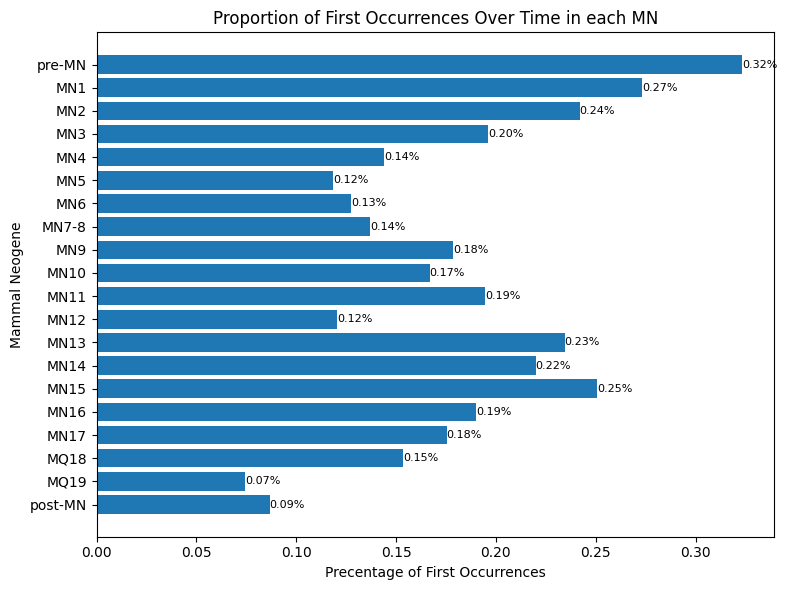

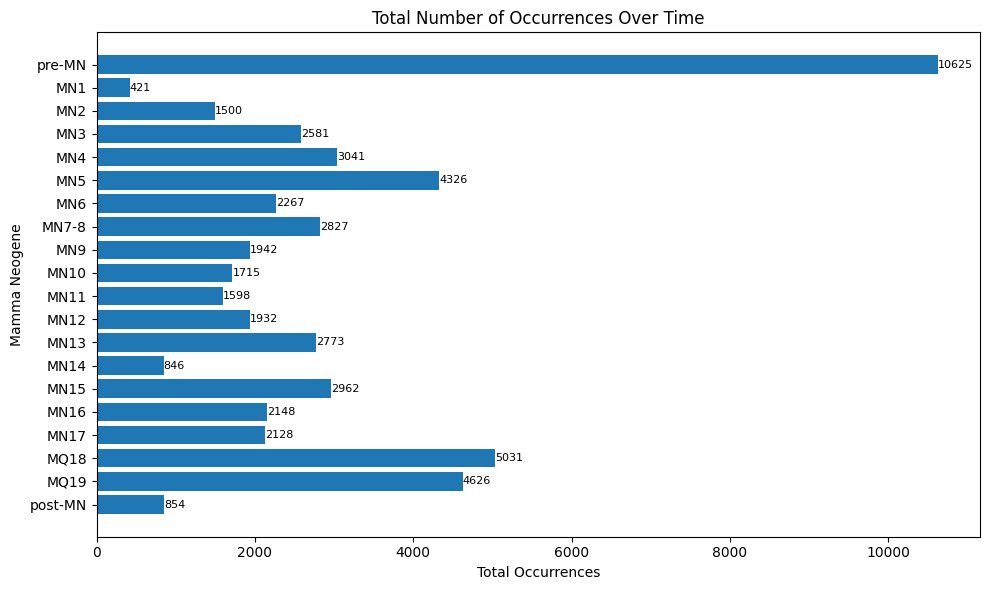

C:\Users\jarpp\AppData\Local\Temp\ipykernel_27020\1154066046.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = (gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')))


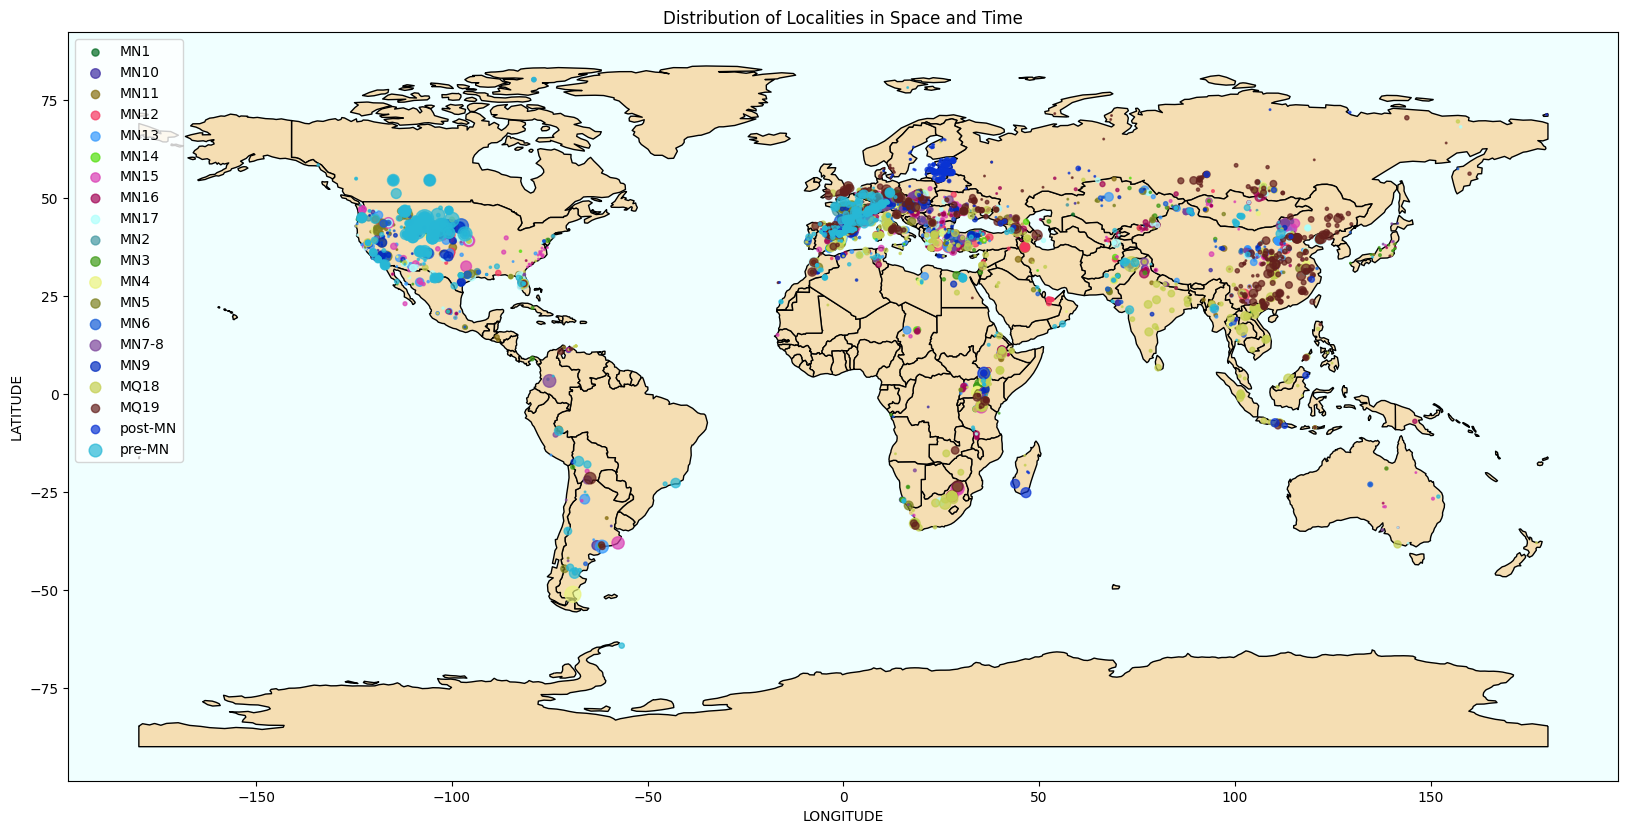

Optimization terminated successfully.
         Current function value: 0.565315
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       FIRST_OCCURRENCE   No. Observations:                16053
Model:                          Logit   Df Residuals:                    16051
Method:                           MLE   Df Model:                            1
Date:                Thu, 24 Aug 2023   Pseudo R-squ.:                  0.1264
Time:                        17:22:48   Log-Likelihood:                -9075.0
converged:                       True   LL-Null:                       -10388.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.4051      0.027     15.210      0.000   

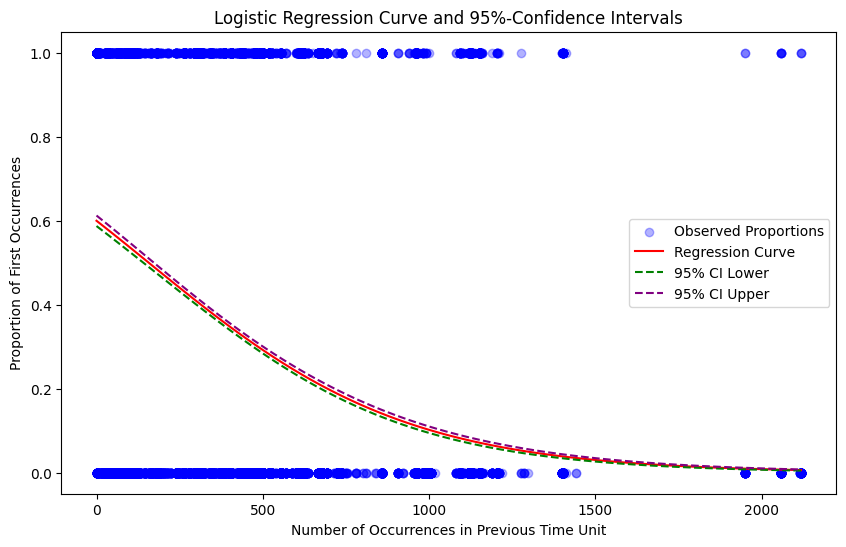

C:\Users\jarpp\AppData\Local\Temp\ipykernel_27020\2162220692.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


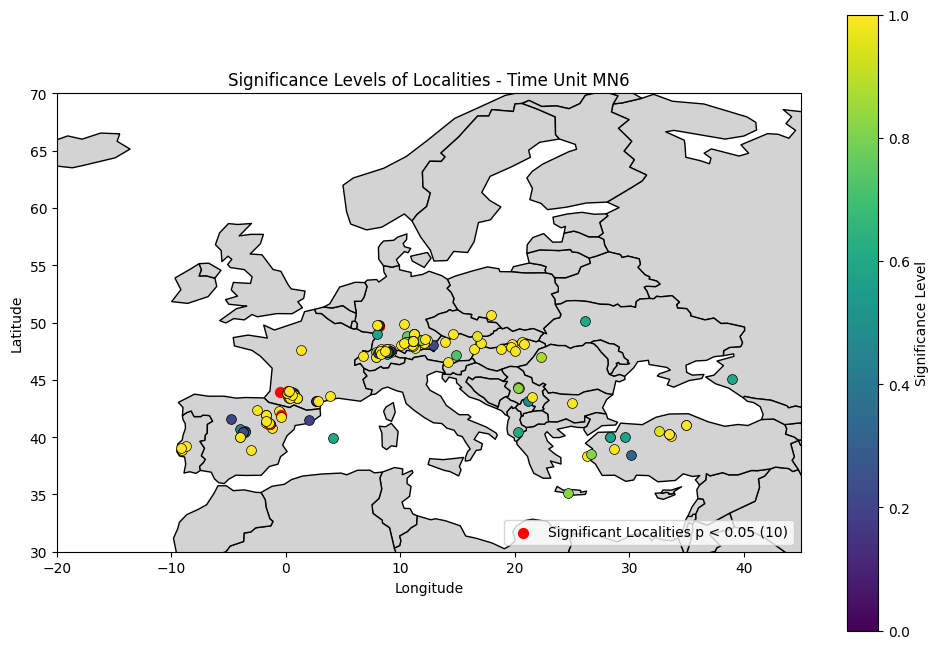

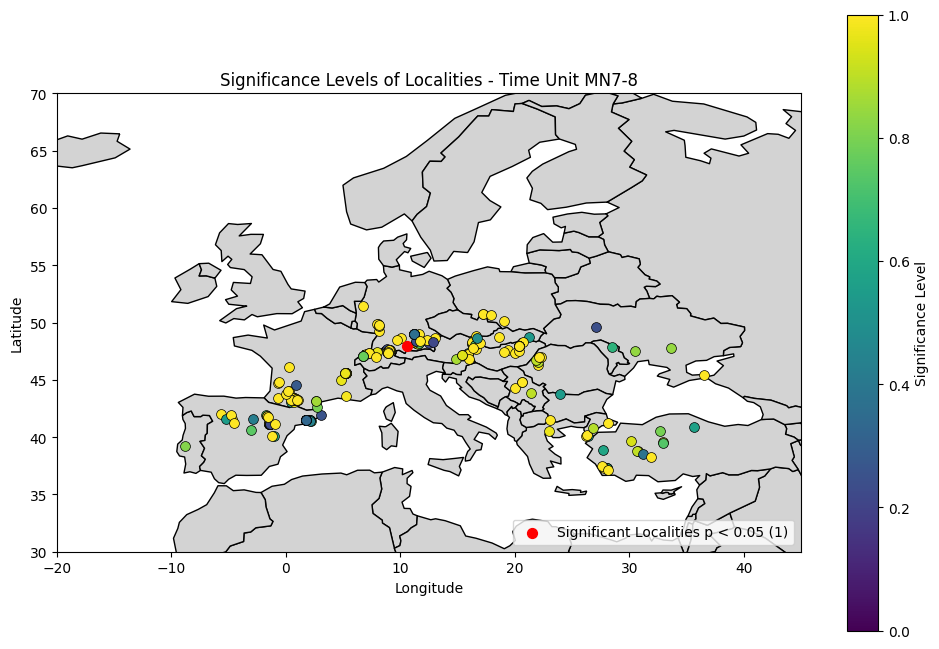

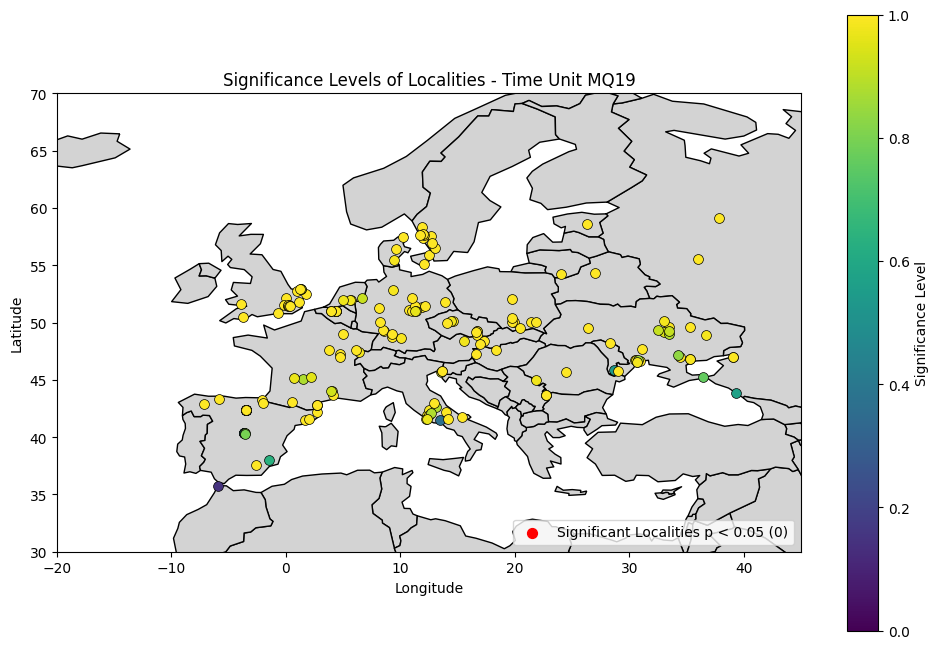

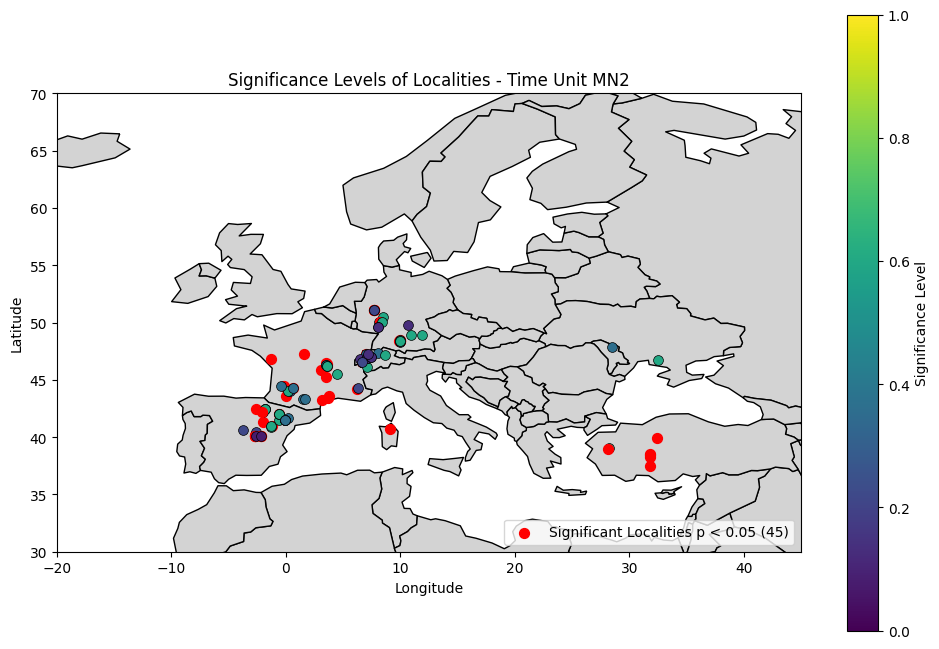

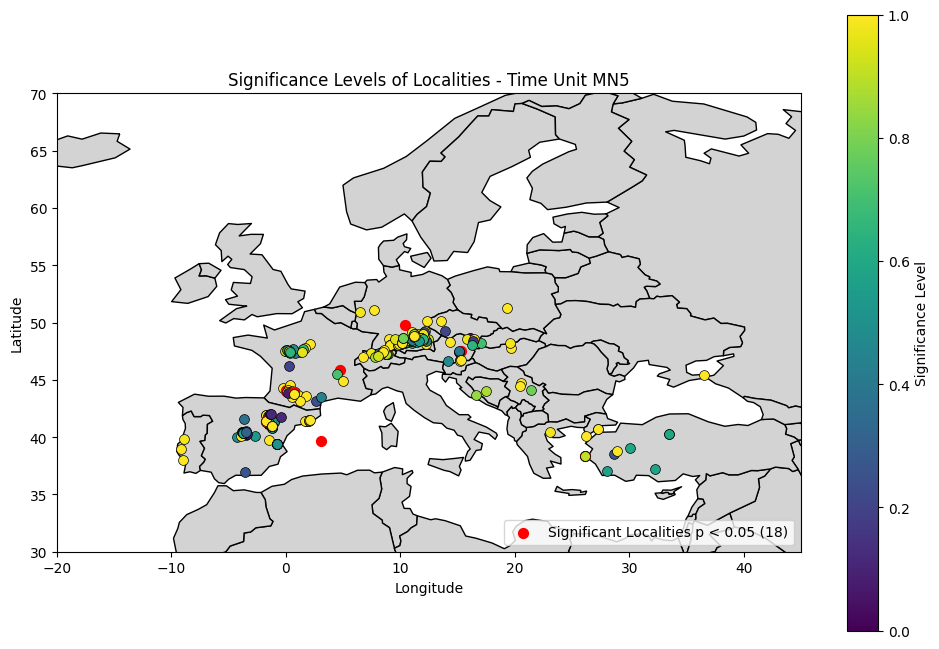

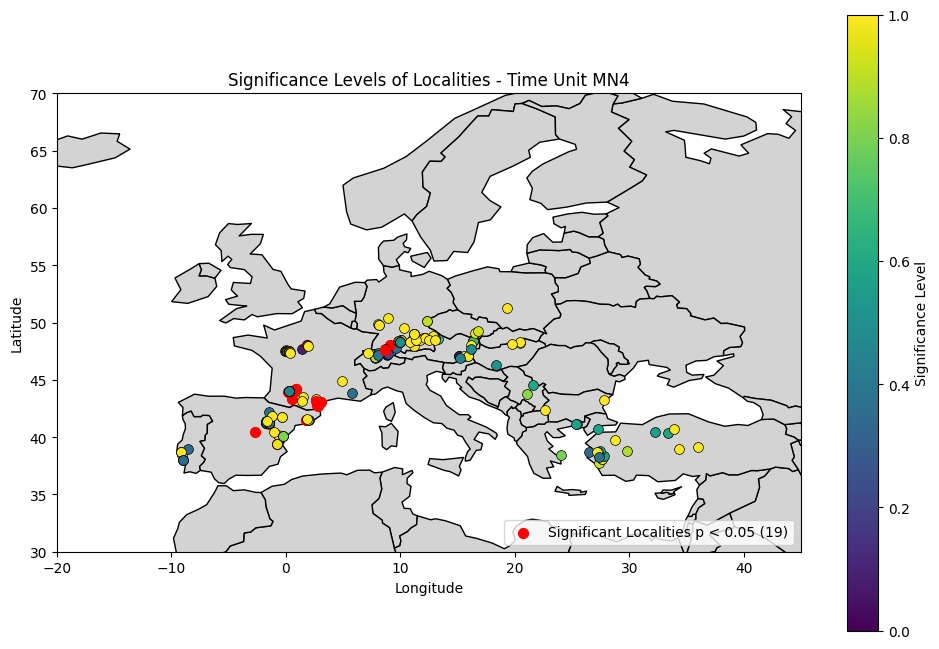

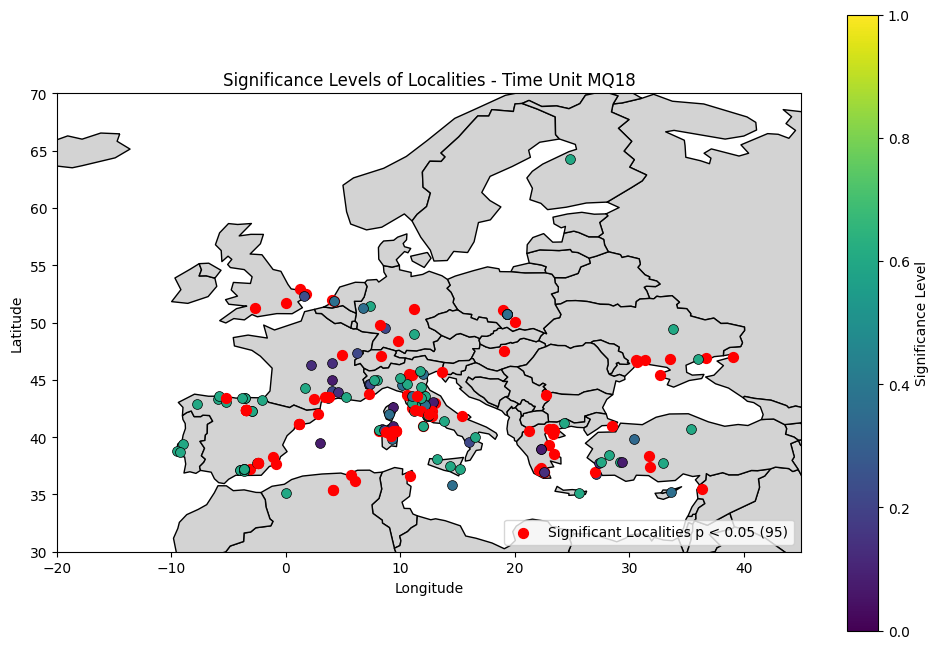

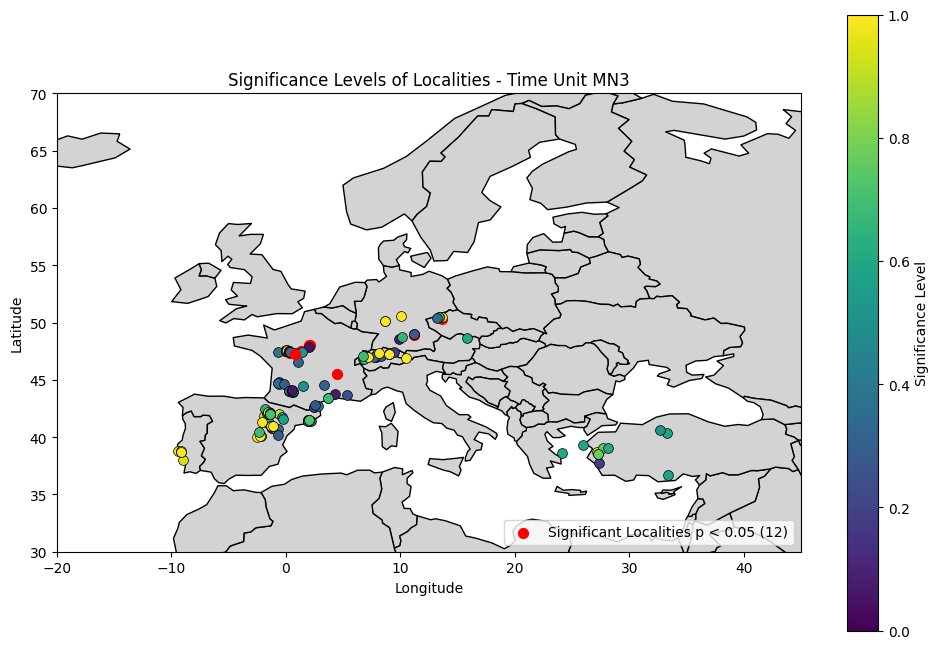

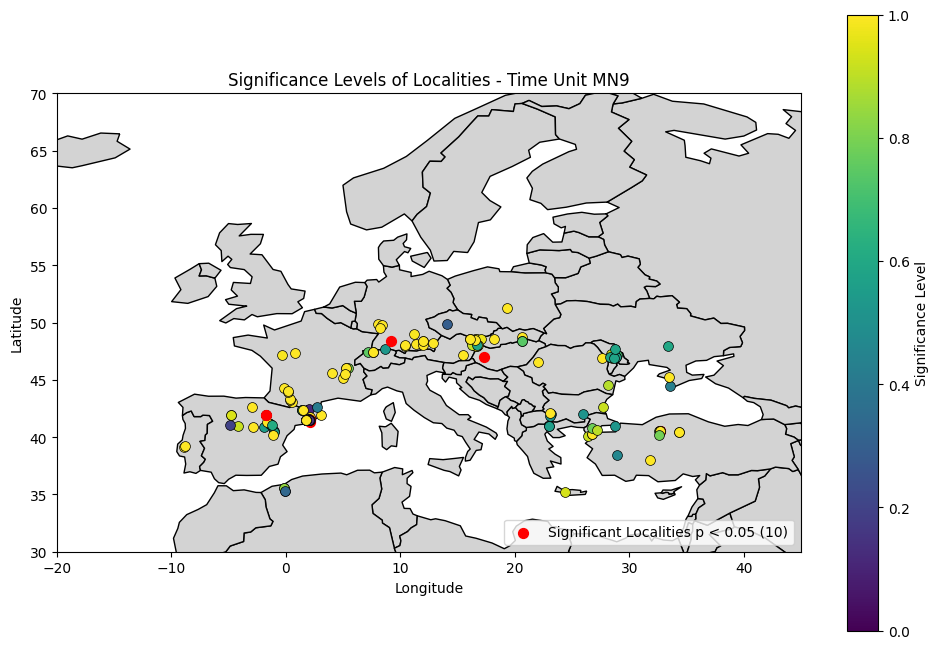

In [85]:
def main():
    # Main function

    # Load and preprocess fossil data
    fossil_data = data()
    fossil_data = mammal_neogene(fossil_data)
    fossil_data = species_id(fossil_data) # 6418 unique localities, 10773 unique species

    # Calculate and analyze fossil occurrences
    occurrences, first_occurrences = fossil_occurrences(fossil_data)
    total_occurrences, total_first_occurrences, proportion_first_occurrences = calculate_occurrences(occurrences, first_occurrences)
    plot_occurrences(total_occurrences, total_first_occurrences, proportion_first_occurrences)

    # Analyze and visualize locality data
    locality_data = locality(fossil_data)
    plot_localities_on_world_map(locality_data)

    # Further analyze locality data at a 10x10 degrees area
    locality_data = locality_10_x_10(locality_data)

    # Perform logistic regression analysis
    merged_data, model = regres(fossil_data)

    # Calculate expected proportions for European localities
    eu_expected_proportions = european_expected_proportion(merged_data, model)

    # Calculate probabilities of observing first occurrences in European localities
    probability_data = calculate_locality_probabilities(merged_data, eu_expected_proportions)

    # Visualize significance levels of localities around Europe over time
    europe_plot(merged_data, eu_expected_proportions, probability_data)
    
    
if __name__ == "__main__":
    main()    